In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import nengo

# Hannas Test Net - Nengo

In [8]:
net = nengo.Network()

In [ ]:
with net:
    node1 = nengo.Node(output=0.5) # use output for input layer, poisson spike function with frequency = pixel intensity
    neurons = []
    for n in range(5):
        neurons.append(nengo.Ensemble(1,2))

# SNN Architecture Null Model

c:\Users\hanna\Downloads\NMC-Project-Code\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


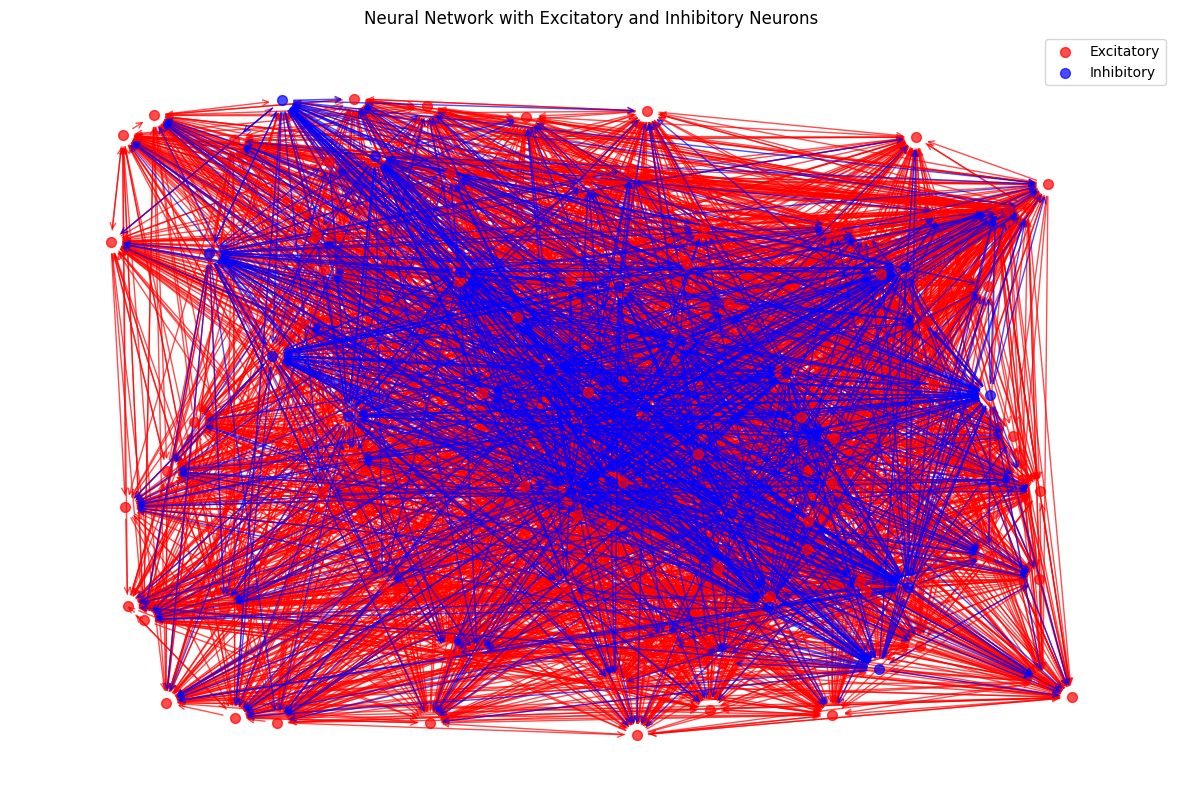

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)
    num_inhibitory = num_neurons - num_excitatory

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = np.random.uniform(0.1, 1.0)  # Positive weight
                else:
                    weight = np.random.uniform(-1.0, -0.1)  # Negative weight
                G.add_edge(i, j, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type="input")

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(0.1, 1.0)  # Positive weight for input connections
                G.add_edge(input_node, target_neuron, weight=weight)

    return G

def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "input"]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)

    # Draw edges
    weights = nx.get_edge_attributes(G, "weight")
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] > 0]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == "input"]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 100  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.4  # 10% connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
#G = add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5)
plot_network(G)

C:\Users\hanna\AppData\Local\Temp\ipykernel_28904\2423104239.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


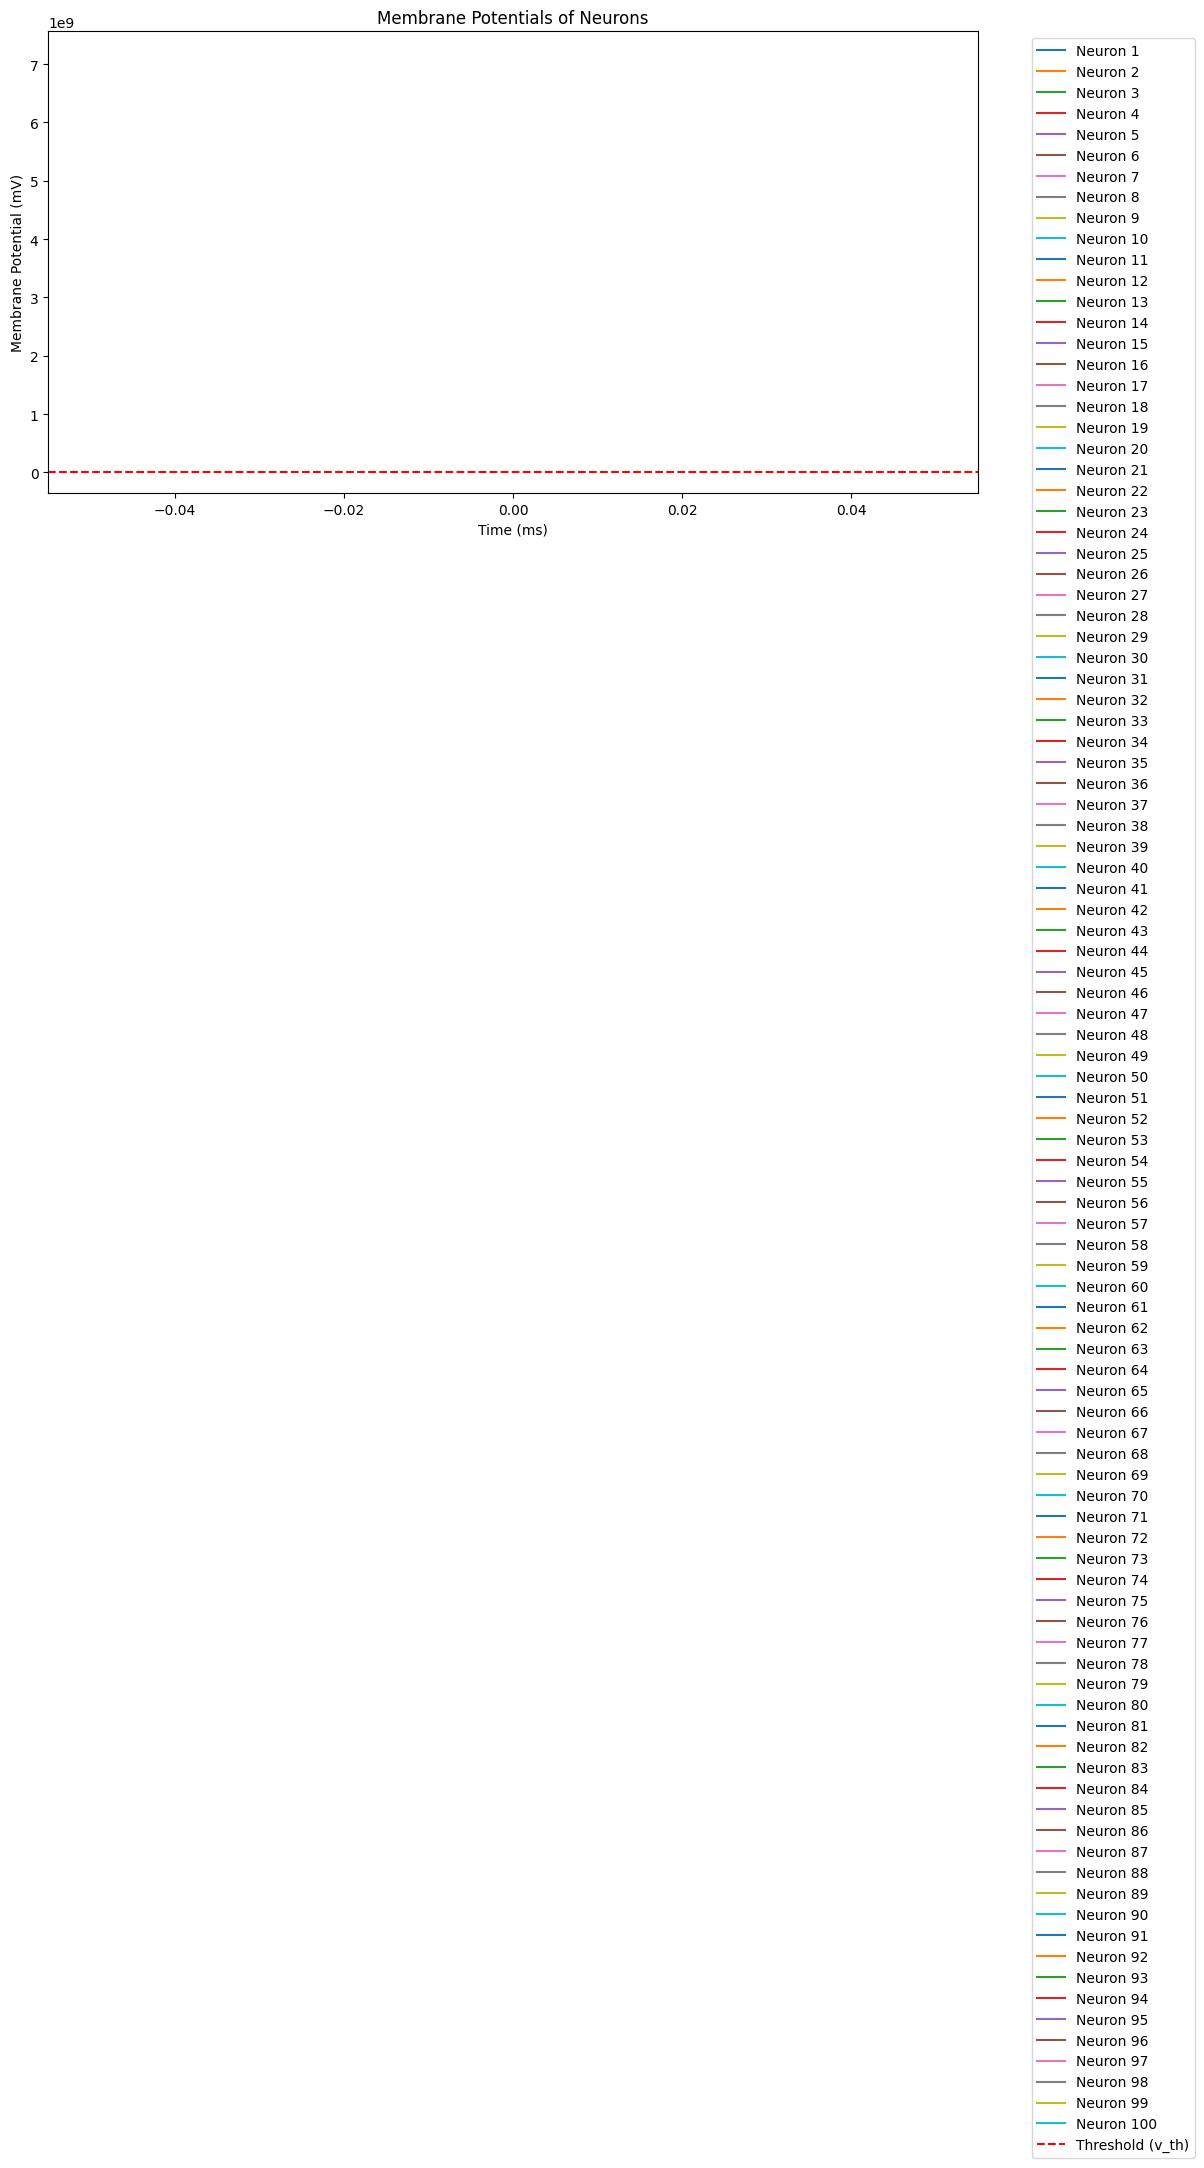

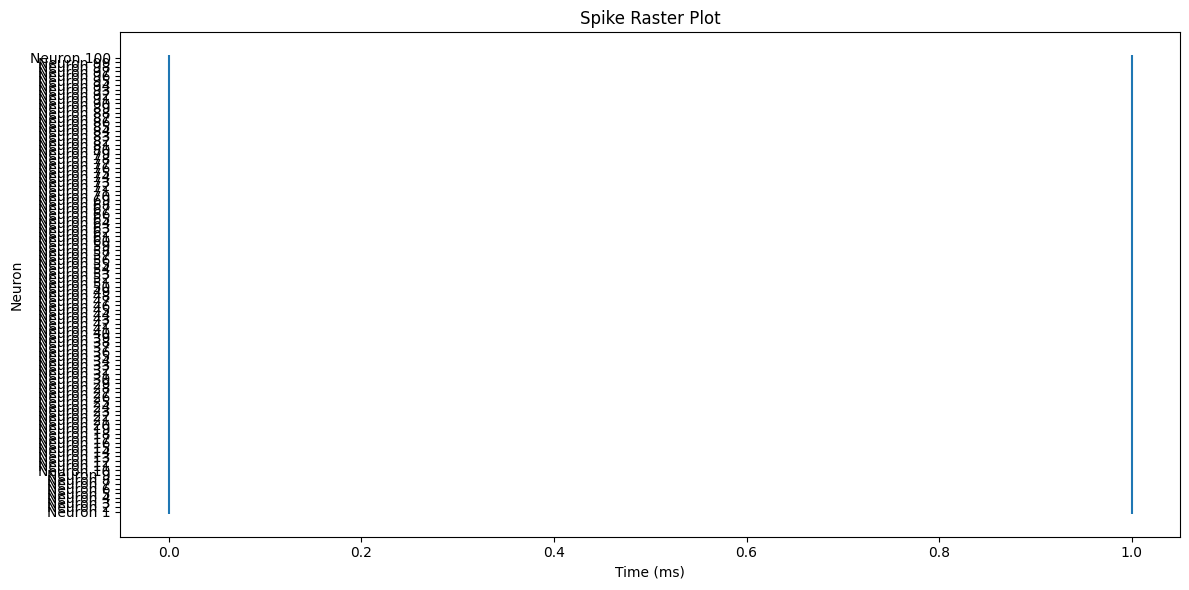

In [21]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax.lax import scan

# Define parameters
N = 100  # Number of neurons
EXCITATORY_RATIO = 0.8  # Ratio of excitatory neurons
EXCITATORY = 1
INHIBITORY = -1

# Define AdEx neuron dynamics
def adex_dynamics(state, params, inputs):
    """Compute AdEx neuron dynamics."""
    v, w = state  # Membrane potential and adaptation variable
    I_ext, I_syn = inputs

    v_rest, v_th, delta_T, tau_v, a, b, tau_w = params

    dvdt = (-(v - v_rest) + delta_T * jnp.exp((v - v_th) / delta_T) - w + I_ext + I_syn) / tau_v
    dwdt = (a * (v - v_rest) - w) / tau_w

    return jnp.array([dvdt, dwdt])

# Define synapse dynamics (placeholder)
def synapse_dynamics(state, params):
    """Compute synapse dynamics (e.g., calcium dynamics)."""
    c, u = state  # Example states (calcium and utilization)
    tau_c, tau_u = params

    dcdt = -c / tau_c  # Calcium decay
    dudt = -u / tau_u  # Utilization decay

    return jnp.array([dcdt, dudt])

# Define STDP rule
def stdp_update(w, pre_spike, post_spike, A_plus, A_minus, tau_plus, tau_minus):
    """Spike-Timing Dependent Plasticity (STDP) rule."""
    dw = (
        A_plus * jnp.exp(-pre_spike / tau_plus) -
        A_minus * jnp.exp(-post_spike / tau_minus)
    )
    return w + dw

# Initialize network with connections based on the graph
def initialize_from_graph(G, key):
    """Initialize neuron types and weights based on a networkx graph."""
    N = len(G.nodes)
    neuron_types = jnp.array([G.nodes[i]['type'] for i in range(N)])  # Extract types
    adjacency_matrix = jnp.array(nx.adjacency_matrix(G).todense())  # Extract connectivity

    # Random weights for existing connections
    key, subkey = random.split(key)
    weights = random.uniform(subkey, shape=(N, N), minval=-1.0, maxval=1.0)
    weights = weights * adjacency_matrix * neuron_types[:, None]  # Apply mask and types

    return neuron_types, weights

# Plot neuron activity
def plot_neuron_activity(time, membrane_potentials, spikes):
    """
    Plot the activity of neurons over time.

    Parameters:
    - time: Array of time points.
    - membrane_potentials: 2D array of shape (N, len(time)) representing the membrane potential of each neuron over time.
    - spikes: 2D array of shape (N, len(time)) indicating spike events (binary: 1 if spiked, 0 otherwise).
    """
    N = membrane_potentials.shape[0]

    # Plot membrane potentials
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time, membrane_potentials[i, :], label=f"Neuron {i+1}")
    plt.axhline(-50, color='red', linestyle='--', label="Threshold (v_th)")
    plt.title("Membrane Potentials of Neurons")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane Potential (mV)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot spike raster
    plt.figure(figsize=(12, 6))
    for i in range(N):
        spike_times = time[spikes[i, :] > 0]
        plt.vlines(spike_times, i + 0.5, i + 1.5)
    plt.title("Spike Raster Plot")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron")
    plt.yticks(range(1, N + 1), labels=[f"Neuron {i+1}" for i in range(N)])
    plt.tight_layout()
    plt.show()

# Simulation function
def simulate(params, T, dt, key):
    """Simulate the network with activity logging."""
    time_steps = jnp.arange(0, T, dt)
    num_steps = len(time_steps)
    neuron_types, weights = initialize_from_graph(G, key)

    neuron_states = jnp.zeros((N, 2))  # [v, w]
    synapse_states = jnp.zeros((N, 2))  # [c, u]
    membrane_potentials = jnp.zeros((N, num_steps))
    spikes = jnp.zeros((N, num_steps))

    carry = (neuron_states, synapse_states, weights, neuron_types, params)

    def network_update(carry, t_idx):
        neuron_states, synapse_states, weights, neuron_types, params = carry

        # Simulate synaptic inputs and neuron states
        I_ext = jnp.ones(N) * 500
        I_syn = jnp.dot(weights, neuron_states[:, 0])
        neuron_states = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
            neuron_states, params['neuron'], jnp.stack([I_ext, I_syn], axis=-1)
        )
        

        # Log activity
        mem_pot = neuron_states[:, 0]
        spk = (mem_pot > params['v_th']).astype(float)

        return (neuron_states, synapse_states, weights, neuron_types, params), (mem_pot, spk)

    _, (membrane_potentials, spikes) = scan(network_update, carry, jnp.arange(num_steps))
    return membrane_potentials.T, spikes.T, time_steps

# Run the simulation
key = random.PRNGKey(42)
T = 1000  # Simulation time in ms
dt = 1.0  # Time step in ms

params = {
    'neuron': (0.0, -50.0, 2.0, 20.0, 0.01, 0.1, 100.0),  # AdEx params
    'synapse': (100.0, 200.0),  # Synapse params
    'stdp': {
        'A_plus': 0.01, 'A_minus': 0.012,
        'tau_plus': 20.0, 'tau_minus': 20.0
    },
    'v_th': -50.0  # Threshold for spikes
}

membrane_potentials, spikes, time = simulate(params, T, dt, key)
plot_neuron_activity(time, membrane_potentials, spikes)


In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax.lax import scan
import matplotlib.pyplot as plt
import networkx as nx

# Define neuron parameters
N = 20  # Number of neurons
EXCITATORY_RATIO = 0.8  # Ratio of excitatory neurons
EXCITATORY = 1
INHIBITORY = -1

# Define AdEx neuron dynamics
def adex_dynamics(state, params, inputs):
    """Compute AdEx neuron dynamics."""
    v, w = state  # Membrane potential and adaptation variable
    I_ext, I_syn = inputs

    v_rest, v_th, delta_T, tau_v, a, b, tau_w = params

    dvdt = (-(v - v_rest) + delta_T * jnp.exp((v - v_th) / delta_T) - w + I_ext + I_syn) / tau_v
    dwdt = (a * (v - v_rest) - w) / tau_w

    return jnp.array([dvdt, dwdt])

# Define synapse dynamics (placeholder)
def synapse_dynamics(state, params):
    """Compute synapse dynamics (e.g., calcium dynamics)."""
    c, u = state  # Example states (calcium and utilization)
    tau_c, tau_u = params

    dcdt = -c / tau_c  # Calcium decay
    dudt = -u / tau_u  # Utilization decay

    return jnp.array([dcdt, dudt])

# Define STDP rule
def stdp_update(w, pre_spike, post_spike, A_plus, A_minus, tau_plus, tau_minus):
    """Spike-Timing Dependent Plasticity (STDP) rule."""
    dw = (
        A_plus * jnp.exp(-pre_spike / tau_plus) -
        A_minus * jnp.exp(-post_spike / tau_minus)
    )
    return w + dw

# Initialize network with connections based on the graph
def initialize_from_graph(G, key):
    """Initialize neuron types and weights based on a networkx graph."""
    N = len(G.nodes)
    neuron_types = jnp.array([G.nodes[i]['type'] for i in range(N)])  # Extract types
    adjacency_matrix = jnp.array(nx.adjacency_matrix(G).todense())  # Extract connectivity

    # Random weights for existing connections
    key, subkey = random.split(key)
    weights = random.uniform(subkey, shape=(N, N), minval=-0.1, maxval=0.1)
    weights = weights * adjacency_matrix * neuron_types[:, None]  # Apply mask and types

    return neuron_types, weights

# Plotting function for neuron activity
def plot_neuron_activity(time, membrane_potentials, spikes):
    """
    Plot the activity of neurons over time.

    Parameters:
    - time: Array of time points.
    - membrane_potentials: 2D array of shape (N, len(time)) representing the membrane potential of each neuron over time.
    - spikes: 2D array of shape (N, len(time)) indicating spike events (binary: 1 if spiked, 0 otherwise).
    """
    N = membrane_potentials.shape[0]

    # Plot membrane potentials
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time, membrane_potentials[i, :], label=f"Neuron {i+1}")
    plt.axhline(-50, color='red', linestyle='--', label="Threshold (v_th)")
    plt.title("Membrane Potentials of Neurons")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane Potential (mV)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot spike raster
    plt.figure(figsize=(12, 6))
    for i in range(N):
        spike_times = time[spikes[i, :] > 0]
        plt.vlines(spike_times, i + 0.5, i + 1.5)
    plt.title("Spike Raster Plot")
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron")
    plt.yticks(range(1, N + 1), labels=[f"Neuron {i+1}" for i in range(N)])
    plt.tight_layout()
    plt.show()

# Simulation function
def simulate(params, T, dt, G, key):
    """Simulate the network with activity logging."""
    key, subkey1, subkey2 = random.split(key, 3)
    neuron_types, weights = initialize_from_graph(G, key)

    # Randomize initial neuron states
    neuron_states = jnp.stack([
        random.uniform(subkey1, shape=(N,), minval=-70.0, maxval=-50.0),  # Membrane potentials
        random.uniform(subkey2, shape=(N,), minval=0.0, maxval=5.0)  # Adaptation variables
    ], axis=-1)

    synapse_states = jnp.zeros((N, 2))  # [c, u]
    carry = (neuron_states, synapse_states, weights, neuron_types, params)

    # Time points and storage
    time_steps = jnp.arange(0, T, dt)
    membrane_potentials = []
    spikes = []

    def network_update(carry, t, key):
        """Update function with activity logging."""
        neuron_states, synapse_states, weights, neuron_types, params = carry

        # External current (small random noise)
        key, subkey = random.split(key)
        I_ext = random.normal(subkey, shape=(N,)) * 5.0  # Gaussian noise

        # Simulate synaptic inputs and neuron states
        I_syn = jnp.dot(weights, neuron_states[:, 0])
        neuron_states = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
            neuron_states, params['neuron'], jnp.stack([I_ext, I_syn], axis=-1)
        )

        # Log activity
        membrane_potentials.append(neuron_states[:, 0])
        spikes.append((neuron_states[:, 0] > params['v_th']).astype(float))

        return (neuron_states, synapse_states, weights, neuron_types, params), None

    # Run simulation
    carry, _ = scan(network_update, carry, time_steps)
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, time_steps

# Example graph for network
G = nx.erdos_renyi_graph(N, 0.2)
for node in G.nodes:
    G.nodes[node]['type'] = EXCITATORY if random.uniform(random.PRNGKey(node)) > 1 - EXCITATORY_RATIO else INHIBITORY

# Parameters for simulation
params = {
    'neuron': (0.0, -50.0, 2.0, 20.0, 0.01, 0.1, 100.0),  # AdEx params
    'synapse': (100.0, 200.0),  # Synapse params
    'stdp': {
        'A_plus': 0.01, 'A_minus': 0.012,
        'tau_plus': 20.0, 'tau_minus': 20.0
    },
    'v_th': -50.0  # Threshold for spikes
}

# Run the simulation
key = random.PRNGKey(42)
T = 1000  # Simulation time in ms
dt = 1.0  # Time step in ms
membrane_potentials, spikes, time = simulate(params, T, dt, G, key)

# Plot activity
plot_neuron_activity(time, membrane_potentials, spikes)


UnboundLocalError: local variable 'key' referenced before assignment